Detects beats from a 60s music and record the timestamps

In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
%matplotlib inline

In [ ]:
# Load the audio (limit to 60s for now)
file_path = 'music/music.mp3'  # or .wav
y, sr = librosa.load(file_path, duration=60)

In [ ]:
# Detect tempo and beats
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

# Convert beat times to timestamps
beat_timestamps = [str(timedelta(seconds=float(t))) for t in beat_times]

# Extract tempo value (handle numpy array case)
tempo_value = tempo[0] if isinstance(tempo, np.ndarray) else tempo

# Print tempo and detected beat timestamps
print(f"Tempo: {tempo_value:.2f} BPM")
print(f"Detected {len(beat_timestamps)} beats:")
for ts in beat_timestamps:
    print(ts)

In [ ]:
# Plot waveform and beats
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.6)
plt.vlines(beat_times, -1, 1, color='r', linestyle='--', label='Beats')
plt.title("Waveform with Beat Markers")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

# --- 2. Method A: Filter by Minimum Gap ---
# Your B-roll clip durations (in seconds)
b_roll_durations = [2.5, 4.0, 3.2, 8.0, 5.0]  

min_gap = min(b_roll_durations)
filtered_beats = []
last_time = -np.inf
for t in beat_times:
    if t - last_time >= min_gap:
        filtered_beats.append(t)
        last_time = t

print(f"Method A → Beats filtered by min_gap={min_gap:.2f}s:")
for t, dur in zip(filtered_beats, b_roll_durations):
    print(f"  Insert {dur:.1f}s clip at {timedelta(seconds=t)}")
print()

In [ ]:
# Visualize filtered beats
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.6)
plt.vlines(filtered_beats, -1, 1, color='g', linestyle='-', label='Filtered Beats')
plt.title("Waveform with Filtered Beats (Method A)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 1. Load audio and detect beats
y, sr = librosa.load("music/music.mp3")
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

# 2. Extract beat snippets
window_size = int(0.5 * sr)  # 0.5 seconds
beat_snippets = []

for beat_time in beat_times:
    center = int(beat_time * sr)
    start = max(0, center - window_size // 2)
    end = min(len(y), center + window_size // 2)
    snippet = y[start:end]
    beat_snippets.append(snippet)

# 3. Convert to MFCC feature vectors
mfcc_features = []

for snippet in beat_snippets:
    mfcc = librosa.feature.mfcc(y=snippet, sr=sr, n_mfcc=13)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_features.append(mfcc_mean)

# 4. Find most similar beat to a selected beat
X = np.array(mfcc_features)
similarity_matrix = cosine_similarity(X)

i = 10  # Choose beat index to compare
similar_beat_index = np.argmax(similarity_matrix[i][np.arange(len(beat_times)) != i])
if similar_beat_index >= i:
    similar_beat_index += 1  # Skip self-match

print(f"Beat {i} is most similar to Beat {similar_beat_index}")
print(f"Timestamps: {beat_times[i]:.2f}s <-> {beat_times[similar_beat_index]:.2f}s")

# 5. Plot waveform with beat markers
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.6)
plt.vlines(beat_times, -1, 1, color='r', linestyle='--', label='All Beats')
plt.vlines(beat_times[i], -1, 1, color='blue', linestyle='-', label='Selected Beat')
plt.vlines(beat_times[similar_beat_index], -1, 1, color='green', linestyle='-', label='Most Similar')
plt.legend()
plt.title("Waveform with Similar Beat Highlighted")
plt.tight_layout()
plt.show()


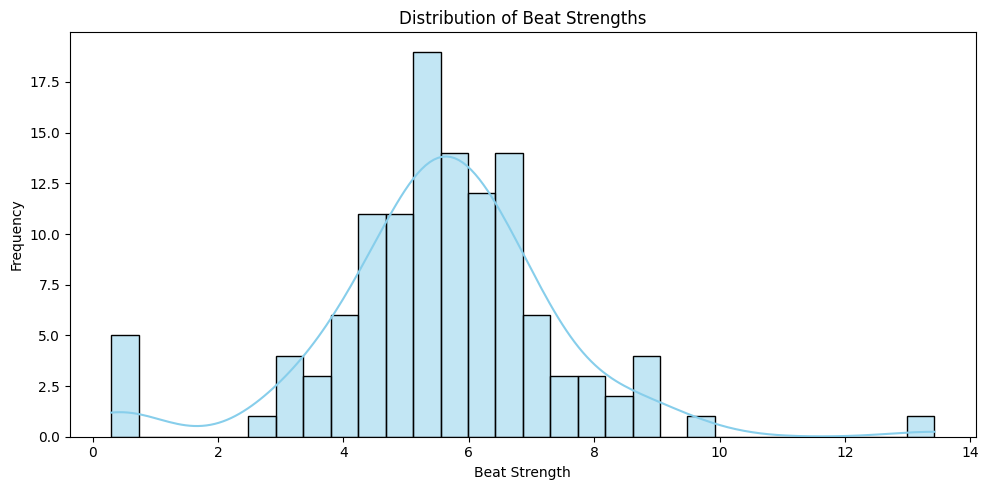

In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Load audio
y, sr = librosa.load("music/music.mp3", duration=60)

# Compute onset envelope
onset_env = librosa.onset.onset_strength(y=y, sr=sr)

# Beat tracking
tempo, beat_frames = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
beat_strengths = onset_env[beat_frames]

# Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(beat_strengths, bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title("Distribution of Beat Strengths")
plt.xlabel("Beat Strength")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [3]:
len(beat_frames)

120

In [4]:
len(beat_strengths)

120

In [5]:
beat_times.size

120

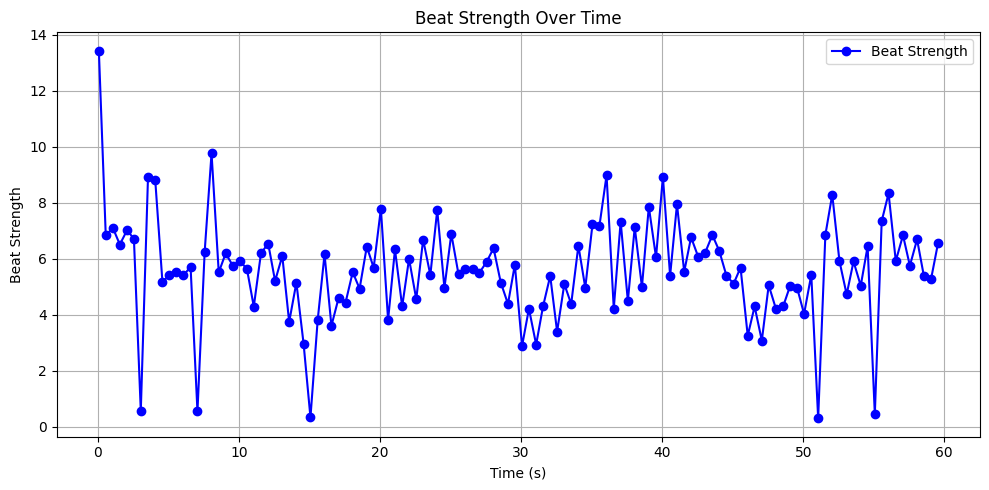

In [6]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(beat_times, beat_strengths, marker='o', linestyle='-', color='b', label='Beat Strength')
plt.title('Beat Strength Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Beat Strength')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def extract_and_plot_dominant_beats(audio_path, bins=30):
    import librosa
    import numpy as np
    import matplotlib.pyplot as plt

    y, sr = librosa.load(audio_path)
    print(f"✅ Audio loaded: {audio_path}")
    
    # Beat tracking
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    print(f"🎵 Detected {len(beat_times)} beats (Tempo: {float(tempo):.2f} BPM)")

    # Compute beat strengths
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    beat_strengths = onset_env[beat_frames]
    
    # Histogram
    counts, bin_edges = np.histogram(beat_strengths, bins=bins)
    max_bin_index = np.argmax(counts)
    dominant_range_start = bin_edges[max_bin_index]
    dominant_range_end = bin_edges[max_bin_index + 1]
    print(f"📊 Dominant strength range: {dominant_range_start:.2f} – {dominant_range_end:.2f}")

    # Filter beats in dominant range
    dominant_beat_times = [
        time for time, strength in zip(beat_times, beat_strengths)
        if dominant_range_start <= strength < dominant_range_end
    ]
    print(f"📍 {len(dominant_beat_times)} beats fall into dominant range.")

    # Plotting
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr, alpha=0.6)
    plt.vlines(dominant_beat_times,  -1, 1, color='blue', linestyle='-', label='Dominant Beats')
    plt.xlabel("Time (s)")
    plt.ylabel("Beat Mark")
    plt.title("Dominant Beat Timestamps Based on Beat Strength")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return dominant_beat_times


In [ ]:
audio_file = "music/music.mp3"
dominant_beats = extract_and_plot_dominant_beats(audio_file)


In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Load audio
y, sr = librosa.load('music/music.mp3', duration=60)

# Short-time Fourier transform
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Plot spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (dB)')
plt.show()


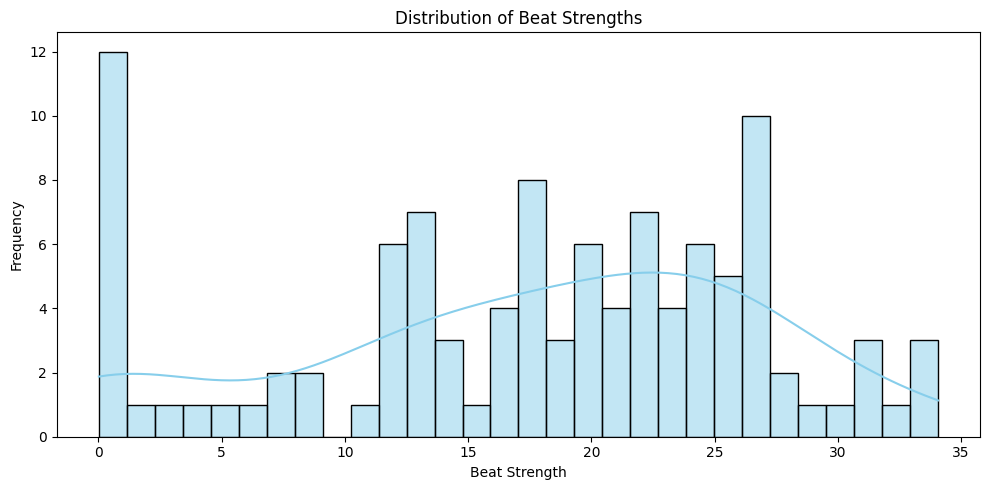

In [43]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Load audio
y, sr = librosa.load("../separated/htdemucs/music/drums.wav", duration=60)

# Compute onset envelope
onset_env = librosa.onset.onset_strength(y=y, sr=sr)

# Beat tracking
tempo, beat_frames = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
beat_strengths = onset_env[beat_frames]

# Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(beat_strengths, bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title("Distribution of Beat Strengths")
plt.xlabel("Beat Strength")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


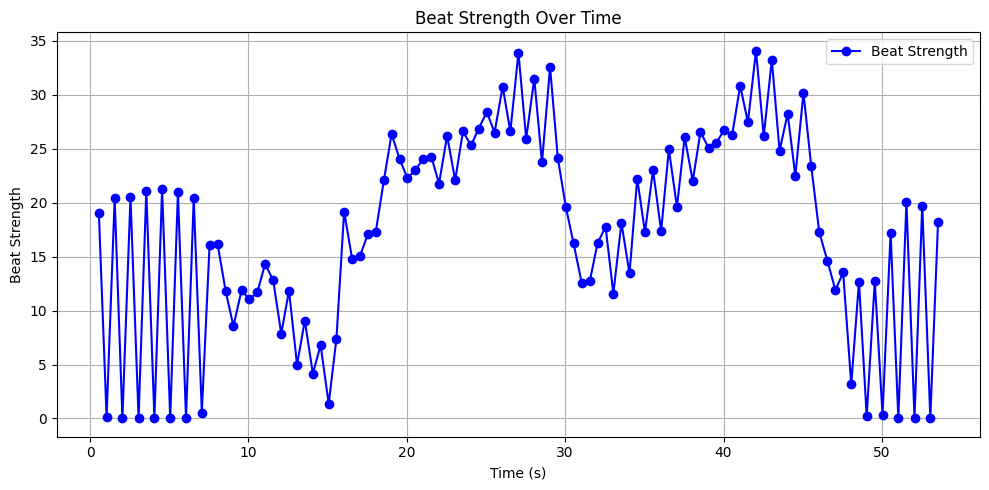

In [44]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(beat_times, beat_strengths, marker='o', linestyle='-', color='b', label='Beat Strength')
plt.title('Beat Strength Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Beat Strength')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

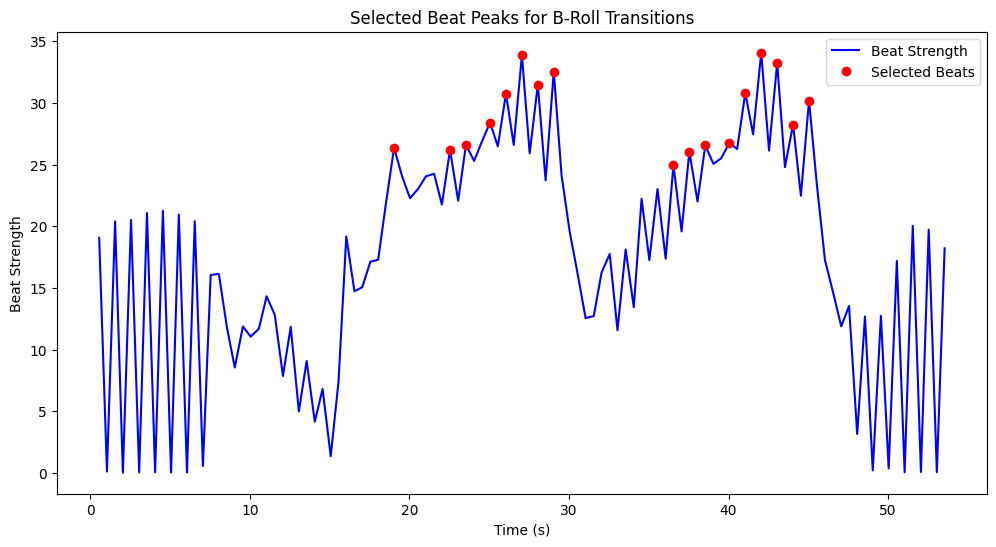

In [9]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np

threshold = np.percentile(beat_strengths, 75)  # top 25% strong beats

# beat_strength is your y-axis array
peaks, _ = find_peaks(beat_strengths, height=threshold)  # optional: use distance=spacing


peaks, _ = find_peaks(beat_strengths, height=threshold)

plt.figure(figsize=(12, 6))
plt.plot(beat_times, beat_strengths, 'b-', label='Beat Strength')
plt.plot(np.array(beat_times)[peaks], np.array(beat_strengths)[peaks], 'ro', label='Selected Beats')
plt.title('Selected Beat Peaks for B-Roll Transitions')
plt.xlabel('Time (s)')
plt.ylabel('Beat Strength')
plt.legend()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (22,) and (107,)

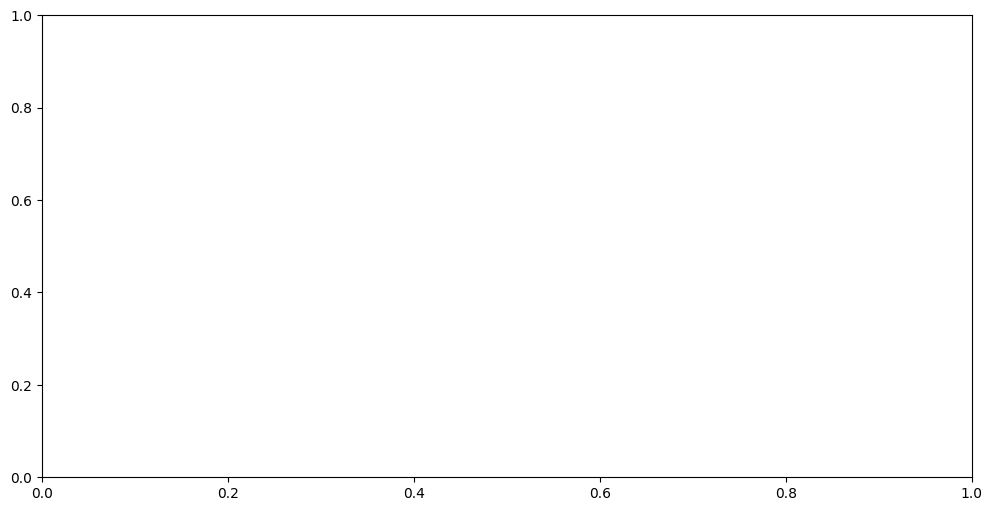

In [41]:
# Step 1: Compute strength threshold
mean = np.mean(beat_strengths)
std = np.std(beat_strengths)
threshold = mean - 0.9*std

# Step 2: Find initial peaks above threshold
peaks, _ = find_peaks(beat_strengths, height=threshold)

# beat_strength is your y-axis array
peaks, _ = find_peaks(beat_strengths, height=threshold)  # optional: use distance=spacing


peaks, _ = find_peaks(beat_strengths, height=threshold)

plt.figure(figsize=(12, 6))
plt.plot(beat_times, beat_strengths, 'b-', label='Beat Strength')
plt.plot(np.array(beat_times)[peaks], np.array(beat_strengths)[peaks], 'ro', label='Selected Beats')
plt.title('Selected Beat Peaks for B-Roll Transitions')
plt.xlabel('Time (s)')
plt.ylabel('Beat Strength')
plt.legend()
plt.show()


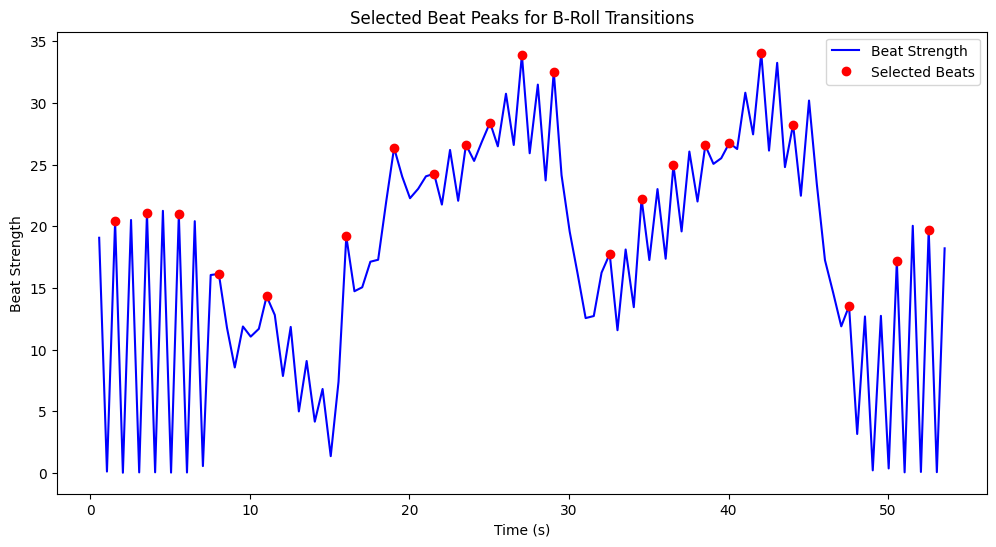

In [11]:
import numpy as np
from scipy.signal import find_peaks

def select_beat_indices(beat_strengths, beat_times):
    beat_strengths = np.array(beat_strengths)
    beat_times = np.array(beat_times)

    # Step 1: Compute strength threshold
    mean = np.mean(beat_strengths)
    std = np.std(beat_strengths)
    threshold = mean - 0.5 * std

    # Step 2: Find initial peaks above threshold
    peaks, _ = find_peaks(beat_strengths, height=threshold)

    # Step 3: Filter based on time gaps
    selected_indices = []
    last_selected_time = -np.inf  # Initialize with negative infinity

    for i in peaks:
        current_time = beat_times[i]

        if not selected_indices:
            # Always accept the first qualifying peak
            selected_indices.append(i)
            last_selected_time = current_time
        else:
            time_gap = current_time - last_selected_time
            if 1.0 <= time_gap <= 10.0:
                selected_indices.append(i)
                last_selected_time = current_time
            elif time_gap > 10.0:
                # If gap is too large, reset and accept this beat
                selected_indices.append(i)
                last_selected_time = current_time
                # (optional) You could also skip it if continuity is important

    return selected_indices


peaks = select_beat_indices(beat_strengths, beat_times)

plt.figure(figsize=(12, 6))
plt.plot(beat_times, beat_strengths, 'b-', label='Beat Strength')
plt.plot(np.array(beat_times)[peaks], np.array(beat_strengths)[peaks], 'ro', label='Selected Beats')
plt.title('Selected Beat Peaks for B-Roll Transitions')
plt.xlabel('Time (s)')
plt.ylabel('Beat Strength')
plt.legend()
plt.show()

In [45]:
selected_beat_times = beat_times

In [46]:
import os
import random
from PIL import Image
from moviepy import ImageSequenceClip, AudioFileClip, concatenate_videoclips, CompositeAudioClip, CompositeVideoClip
from moviepy.video.VideoClip import ImageClip

def create_beat_transition_video(beat_times, audio_file, output_file="beat_video.mp4"):
    fps = 30
    width, height = 1280, 720
    image_folder = "temp_beat_images"
    os.makedirs(image_folder, exist_ok=True)

    # Step 1: Dynamically generate color images based on beat_times
    def random_color():
        return tuple(random.randint(0, 255) for _ in range(3))

    clips = []
    for i in range(len(beat_times)):
        if i == 0:
            duration = beat_times[i]
        else:
            duration = beat_times[i] - beat_times[i-1]
        color = random_color()
        img = Image.new('RGB', (width, height), color=color)
        img_path = os.path.join(image_folder, f"img_{i:03d}.png")
        img.save(img_path)
        clip = ImageClip(img_path, duration=duration)
        clips.append(clip)

    # Concatenate all image clips
    final_video = concatenate_videoclips(clips, method="compose")

    # Add and sync audio
    audio = AudioFileClip(audio_file)
    final_video.audio = audio

    # Write the final video
    final_video.write_videofile(output_file, fps=24)

    # Clean up
    for f in os.listdir(image_folder):
        os.remove(os.path.join(image_folder, f))
    os.rmdir(image_folder)


In [47]:
# Example usage
beat_times = selected_beat_times
audio_file = "../separated/htdemucs/music/drums.wav"          # Your music file

create_beat_transition_video(beat_times, audio_file)

MoviePy - Building video beat_video.mp4.
MoviePy - Writing audio in beat_videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video beat_video.mp4



MoviePy - Done !
MoviePy - video ready beat_video.mp4
